# Wi-Fi Network Security Threat Detection Using Machine Learning

In [1]:
# Define the path to the pcap files and the output directory
pcap_directory = "../datasets/wifi"
output_directory = "./model_output/wifi"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.utils import rdpcap
from scapy.layers.inet import IP
import joblib
import warnings
from datetime import datetime
import os
from scipy import stats

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, precision_recall_curve,
                           average_precision_score, confusion_matrix,
                           roc_curve, auc, silhouette_score)
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

## 1. Load PCAP Files

In [3]:
# Load csv file
raw_df = pd.read_csv('../datasets/wifi/output_1201_new.csv')
synthetic_df = pd.read_csv('../datasets/synthetic_wifi_new.csv')

# Merge two dataframes
df_original = pd.concat([raw_df, synthetic_df], ignore_index=True)
df = df_original.copy()

print(df.columns)

Index(['frame.time_epoch', 'frame.len', 'frame.protocols', 'wlan.fc.type',
       'wlan.fc.subtype', 'wlan.sa', 'wlan.da', 'wlan.bssid',
       'radiotap.channel.freq', 'radiotap.dbm_antsignal', 'radiotap.datarate',
       'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport', 'udp.srcport',
       'udp.dstport', 'tcp.flags', 'tcp.len', 'udp.length', 'tcp.stream',
       'tcp.seq', 'tcp.ack', '_ws.col.protocol', 'label'],
      dtype='object')


In [4]:
print(df.shape)
print(df.head())
print(df.columns)

(14427149, 25)
   frame.time_epoch  frame.len              frame.protocols  wlan.fc.type  \
0      1.729577e+09       1363  eth:ethertype:ipv6:udp:mdns           NaN   
1      1.729577e+09         66         eth:ethertype:ip:tcp           NaN   
2      1.729577e+09         54         eth:ethertype:ip:tcp           NaN   
3      1.729577e+09         42            eth:ethertype:arp           NaN   
4      1.729577e+09         83    eth:ethertype:ip:udp:data           NaN   

   wlan.fc.subtype wlan.sa wlan.da wlan.bssid  radiotap.channel.freq  \
0              NaN     NaN     NaN        NaN                    NaN   
1              NaN     NaN     NaN        NaN                    NaN   
2              NaN     NaN     NaN        NaN                    NaN   
3              NaN     NaN     NaN        NaN                    NaN   
4              NaN     NaN     NaN        NaN                    NaN   

   radiotap.dbm_antsignal  ...  udp.srcport udp.dstport tcp.flags  tcp.len  \
0          

In [5]:
# Display dtypes for each column
for col in df.columns:
    # Display only object or string dtype
    if df[col].dtype == 'O':
        print(f'{col}: {df[col].dtype}')
        print(df[col].unique())
    

frame.protocols: object
['eth:ethertype:ipv6:udp:mdns' 'eth:ethertype:ip:tcp' 'eth:ethertype:arp'
 'eth:ethertype:ip:udp:data' 'eth:ethertype:ip:udp:mdns'
 'eth:ethertype:ip:tcp:ssh' 'eth:ethertype:ip:tcp:data'
 'eth:ethertype:ip:tcp:tls' 'eth:ethertype:ip:tcp:lbmsrs'
 'eth:ethertype:ip:udp:dns'
 'eth:ethertype:ip:tcp:tls:x509sat:x509sat:x509sat:x509sat:x509ce:x509ce:x509ce:x509ce:x509ce:x509ce:x509ce:pkix1implicit:x509ce:tls:x509sat:x509sat:x509sat:x509sat:x509sat:x509sat:x509ce:x509ce:x509ce:x509ce:x509ce:pkix1implicit:x509ce:x509ce:x509sat:x509sat:x509sat:x509sat:x509sat:x509sat:x509sat:x509sat:x509ce:x509ce:x509ce:x509ce:pkix1implicit:x509ce:x509ce:x509sat:x509sat:x509sat:x509sat:x509sat:x509sat:x509sat:x509sat:x509ce:x509ce:x509ce:x509ce:pkix1implicit:x509ce:x509ce:tls'
 'eth:ethertype:ip:tcp:tls:tls' 'eth:ethertype:ip:tcp:http:data'
 'eth:ethertype:ip:tcp:http' 'eth:ethertype:ip:udp:quic:tls'
 'eth:ethertype:ip:udp:quic:tls:tls:tls' 'eth:ethertype:ip:udp:quic'
 'eth:ethertype:ip:

In [6]:
# Display NaN amount of each column
print(df.isna().sum())

frame.time_epoch                 0
frame.len                        0
frame.protocols                  0
wlan.fc.type              14427144
wlan.fc.subtype           14427144
wlan.sa                   14427144
wlan.da                   14427144
wlan.bssid                14427144
radiotap.channel.freq     14427149
radiotap.dbm_antsignal    14427149
radiotap.datarate         14427149
ip.src                      381880
ip.dst                      381880
tcp.srcport                1076691
tcp.dstport                1076691
udp.srcport               13396535
udp.dstport               13396535
tcp.flags                  1076691
tcp.len                    1077317
udp.length                13396535
tcp.stream                 1076691
tcp.seq                    1076691
tcp.ack                    1076691
_ws.col.protocol                 0
label                     10551408
dtype: int64


In [7]:
# Drop columns with constant values
df = df.loc[:, df.nunique() >1]

print(len(df.columns))

17


In [8]:
# Drop sparse columns (>95% missing)
sparse_columns = df.isnull().mean() > 0.9
df = df.loc[:, ~sparse_columns]

print(len(df.columns))

14


In [9]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
print(df.shape)

ip.src           381880
ip.dst           381880
tcp.srcport     1076691
tcp.dstport     1076691
tcp.flags       1076691
tcp.len         1077317
tcp.stream      1076691
tcp.seq         1076691
tcp.ack         1076691
label          10551408
dtype: int64
(14427149, 14)


### Fill NaN

In [10]:
df['ip.src'] = df['ip.src'].fillna('unknown')
df['ip.dst'] = df['ip.dst'].fillna('unknown')

tcp_columns = [
    'tcp.srcport', 'tcp.dstport', 'tcp.flags', 
    'tcp.len', 'tcp.stream', 'tcp.seq', 'tcp.ack'
]
df[tcp_columns] = df[tcp_columns].fillna(0)

In [11]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
print(df.shape)

label    10551408
dtype: int64
(14427149, 14)


### Drop low frequency rows to reduce the dimension after apply Encoder

In [13]:
# Drop rows that it's _ws.col.protocol appears less than 1000 times
df = df[df['_ws.col.protocol'].map(df['_ws.col.protocol'].value_counts()) > 1000]

print(df['_ws.col.protocol'].value_counts())

_ws.col.protocol
TCP          7090292
SSH          5656527
UDP           696880
WebSocket     316138
TLSv1.2       184829
ICMP          175446
MDNS           88297
TLSv1.3        78890
QUIC           46864
TFTP           35243
DNS            27891
SSLv2           8938
SSHv2           6910
TLSv1           5418
ARP             3052
ICMPv6          1335
HTTP            1041
Name: count, dtype: int64


In [18]:
# Drop rows that it's frame.protocols appears less than 1000 times
df = df[df['frame.protocols'].map(df['frame.protocols'].value_counts()) > 1000]

print(df['frame.protocols'].value_counts())

frame.protocols
eth:ethertype:ip:tcp                                                                                                                                                                                                                   6097964
eth:ethertype:ip:tcp:ssh                                                                                                                                                                                                               5663442
eth:ethertype:ip:tcp:data                                                                                                                                                                                                               688081
eth:ethertype:ip:udp:data                                                                                                                                                                                                               629683
eth:ethertype:ipv6:tcp      

In [20]:
# Drop rows that it's ip.src appears less than 1000 times
df = df[df['ip.src'].map(df['ip.src'].value_counts()) > 1000]

print(df['ip.src'].value_counts())

ip.src
192.168.4.1                6632664
192.168.4.11               3997026
192.168.4.6                 532868
unknown                     381603
192.168.4.4                 328143
192.168.4.13                221165
192.168.4.16                162007
192.168.4.4,192.168.4.6     131311
188.5.84.180                109559
104.234.249.183             106473
142.251.215.251              80826
13.38.185.239                64683
142.250.69.202               34929
142.251.215.238              27577
142.251.211.234              24875
142.251.215.234              19358
17.32.214.124                17035
142.251.33.74                10507
17.253.31.139                 8717
192.168.4.12                  6193
192.168.4.3                   5548
64.114.246.144                3816
20.189.172.33                 3767
20.189.172.32                 3033
172.64.147.252                2445
160.79.104.10                 2368
198.41.192.67                 2237
51.96.21.36                   2195
198.41.192.47

In [21]:
# Drop rows that it's ip.dst appears less than 1000 times
df = df[df['ip.dst'].map(df['ip.dst'].value_counts()) > 1000]

print(df['ip.dst'].value_counts())

ip.dst
192.168.4.11               6779055
192.168.4.1                3904212
192.168.4.4                 689902
unknown                     381603
192.168.4.13                327117
192.168.4.6                 208859
192.168.4.6,192.168.4.4     131311
192.168.4.16                117381
224.0.0.251                  70111
104.234.249.183              59413
142.251.211.234              51512
142.250.69.202               33630
142.251.215.251              22729
142.251.33.74                20167
142.251.215.238              18192
142.251.215.234              11552
192.168.4.3                   6317
17.32.214.124                 5497
20.189.172.33                 4930
16.62.129.100                 4469
20.189.172.32                 3072
17.253.31.139                 2941
198.41.192.67                 2728
198.41.200.63                 2584
192.168.4.255                 2549
198.41.192.47                 2461
198.41.200.33                 2060
140.82.113.21                 1970
198.41.200.19

In [22]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Example for low cardinality categorical features
categorical_features = ['frame.protocols', '_ws.col.protocol']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Alternatively, for high cardinality, use label encoding
label_encoder = LabelEncoder()
df['ip.src'] = label_encoder.fit_transform(df['ip.src'])
df['ip.dst'] = label_encoder.fit_transform(df['ip.dst'])

### Standardization / Normalization

In [23]:
# Process tcp.flags, as it contains a mix of hex and string values
df['tcp.flags'] = df['tcp.flags'].fillna('0x0000')  # Replace NaN with a default value

flag_mapping = {
    'SYN': 0x0002  # Extend as needed for other textual flags
}

def convert_tcp_flags(flag):
    if isinstance(flag, str):
        # Check if the flag is a textual representation
        if flag in flag_mapping:
            return flag_mapping[flag]
        # Otherwise, convert hexadecimal to integer
        elif flag.startswith('0x'):
            return int(flag, 16)
    return 0  # Default value for unexpected cases

df['tcp.flags'] = df['tcp.flags'].apply(convert_tcp_flags)

print(df['tcp.flags'].head())
print(df['tcp.flags'].dtype)  # Should show int or float

0     0
1    16
3     0
4     0
5     0
Name: tcp.flags, dtype: int64
int64


In [24]:
from sklearn.preprocessing import StandardScaler

numerical_features = [
    'frame.time_epoch', 'frame.len', 'tcp.srcport', 
    'tcp.dstport', 'tcp.flags', 'tcp.len',  'tcp.stream', 
    'tcp.seq', 'tcp.ack'
]

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

## Feature Engineering

### Temporal Features

In [25]:
df['frame.time_epoch'] = pd.to_numeric(df['frame.time_epoch'], errors='coerce')
df = df.sort_values('frame.time_epoch')

df['time_diff'] = df['frame.time_epoch'].diff().fillna(0)
# Optionally, create rolling statistics
df['time_diff_mean'] = df['time_diff'].rolling(window=10).mean().fillna(0)
df['time_diff_std'] = df['time_diff'].rolling(window=10).std().fillna(0)

### Protocol-based Features

In [26]:
df['is_tcp'] = df_original['_ws.col.protocol'].str.contains('TCP').astype(int)
df['is_udp'] = df_original['_ws.col.protocol'].str.contains('UDP').astype(int)

### Network Flow Features

In [27]:
flow_features = df.groupby('tcp.stream').agg({
    'frame.len': ['mean', 'sum', 'count'],
    'tcp.flags': lambda x: x.sum(),
    'time_diff': ['mean', 'sum']
})
flow_features.columns = ['_'.join(col).strip() for col in flow_features.columns.values]
df = df.join(flow_features, on='tcp.stream', rsuffix='_agg')

### Feature Selection

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
print(corr_matrix)

                    frame.time_epoch  frame.len    ip.src    ip.dst  \
frame.time_epoch            1.000000   0.029225 -0.025386 -0.013834   
frame.len                   0.029225   1.000000 -0.264530  0.013021   
ip.src                     -0.025386  -0.264530  1.000000  0.737921   
ip.dst                     -0.013834   0.013021  0.737921  1.000000   
tcp.srcport                 0.040883  -0.346151  0.270293  0.032190   
...                              ...        ...       ...       ...   
frame.len_sum              -0.505513   0.301613 -0.105467 -0.067894   
frame.len_count             0.580101  -0.045332 -0.020553  0.004157   
tcp.flags_<lambda>         -0.687625   0.041396 -0.048901 -0.076386   
time_diff_mean_agg          0.157917   0.254051 -0.153578 -0.058794   
time_diff_sum               0.644191   0.009167 -0.001911  0.041995   

                    tcp.srcport  tcp.dstport  tcp.flags   tcp.len  tcp.stream  \
frame.time_epoch       0.040883    -0.023142  -0.111343  0.029858 

In [ ]:
# Find features with high correlation
high_corr = corr_matrix[abs(corr_matrix) > 0.9]
high_corr = high_corr[high_corr < 1.0]
print(high_corr.stack().dropna().to_dict())

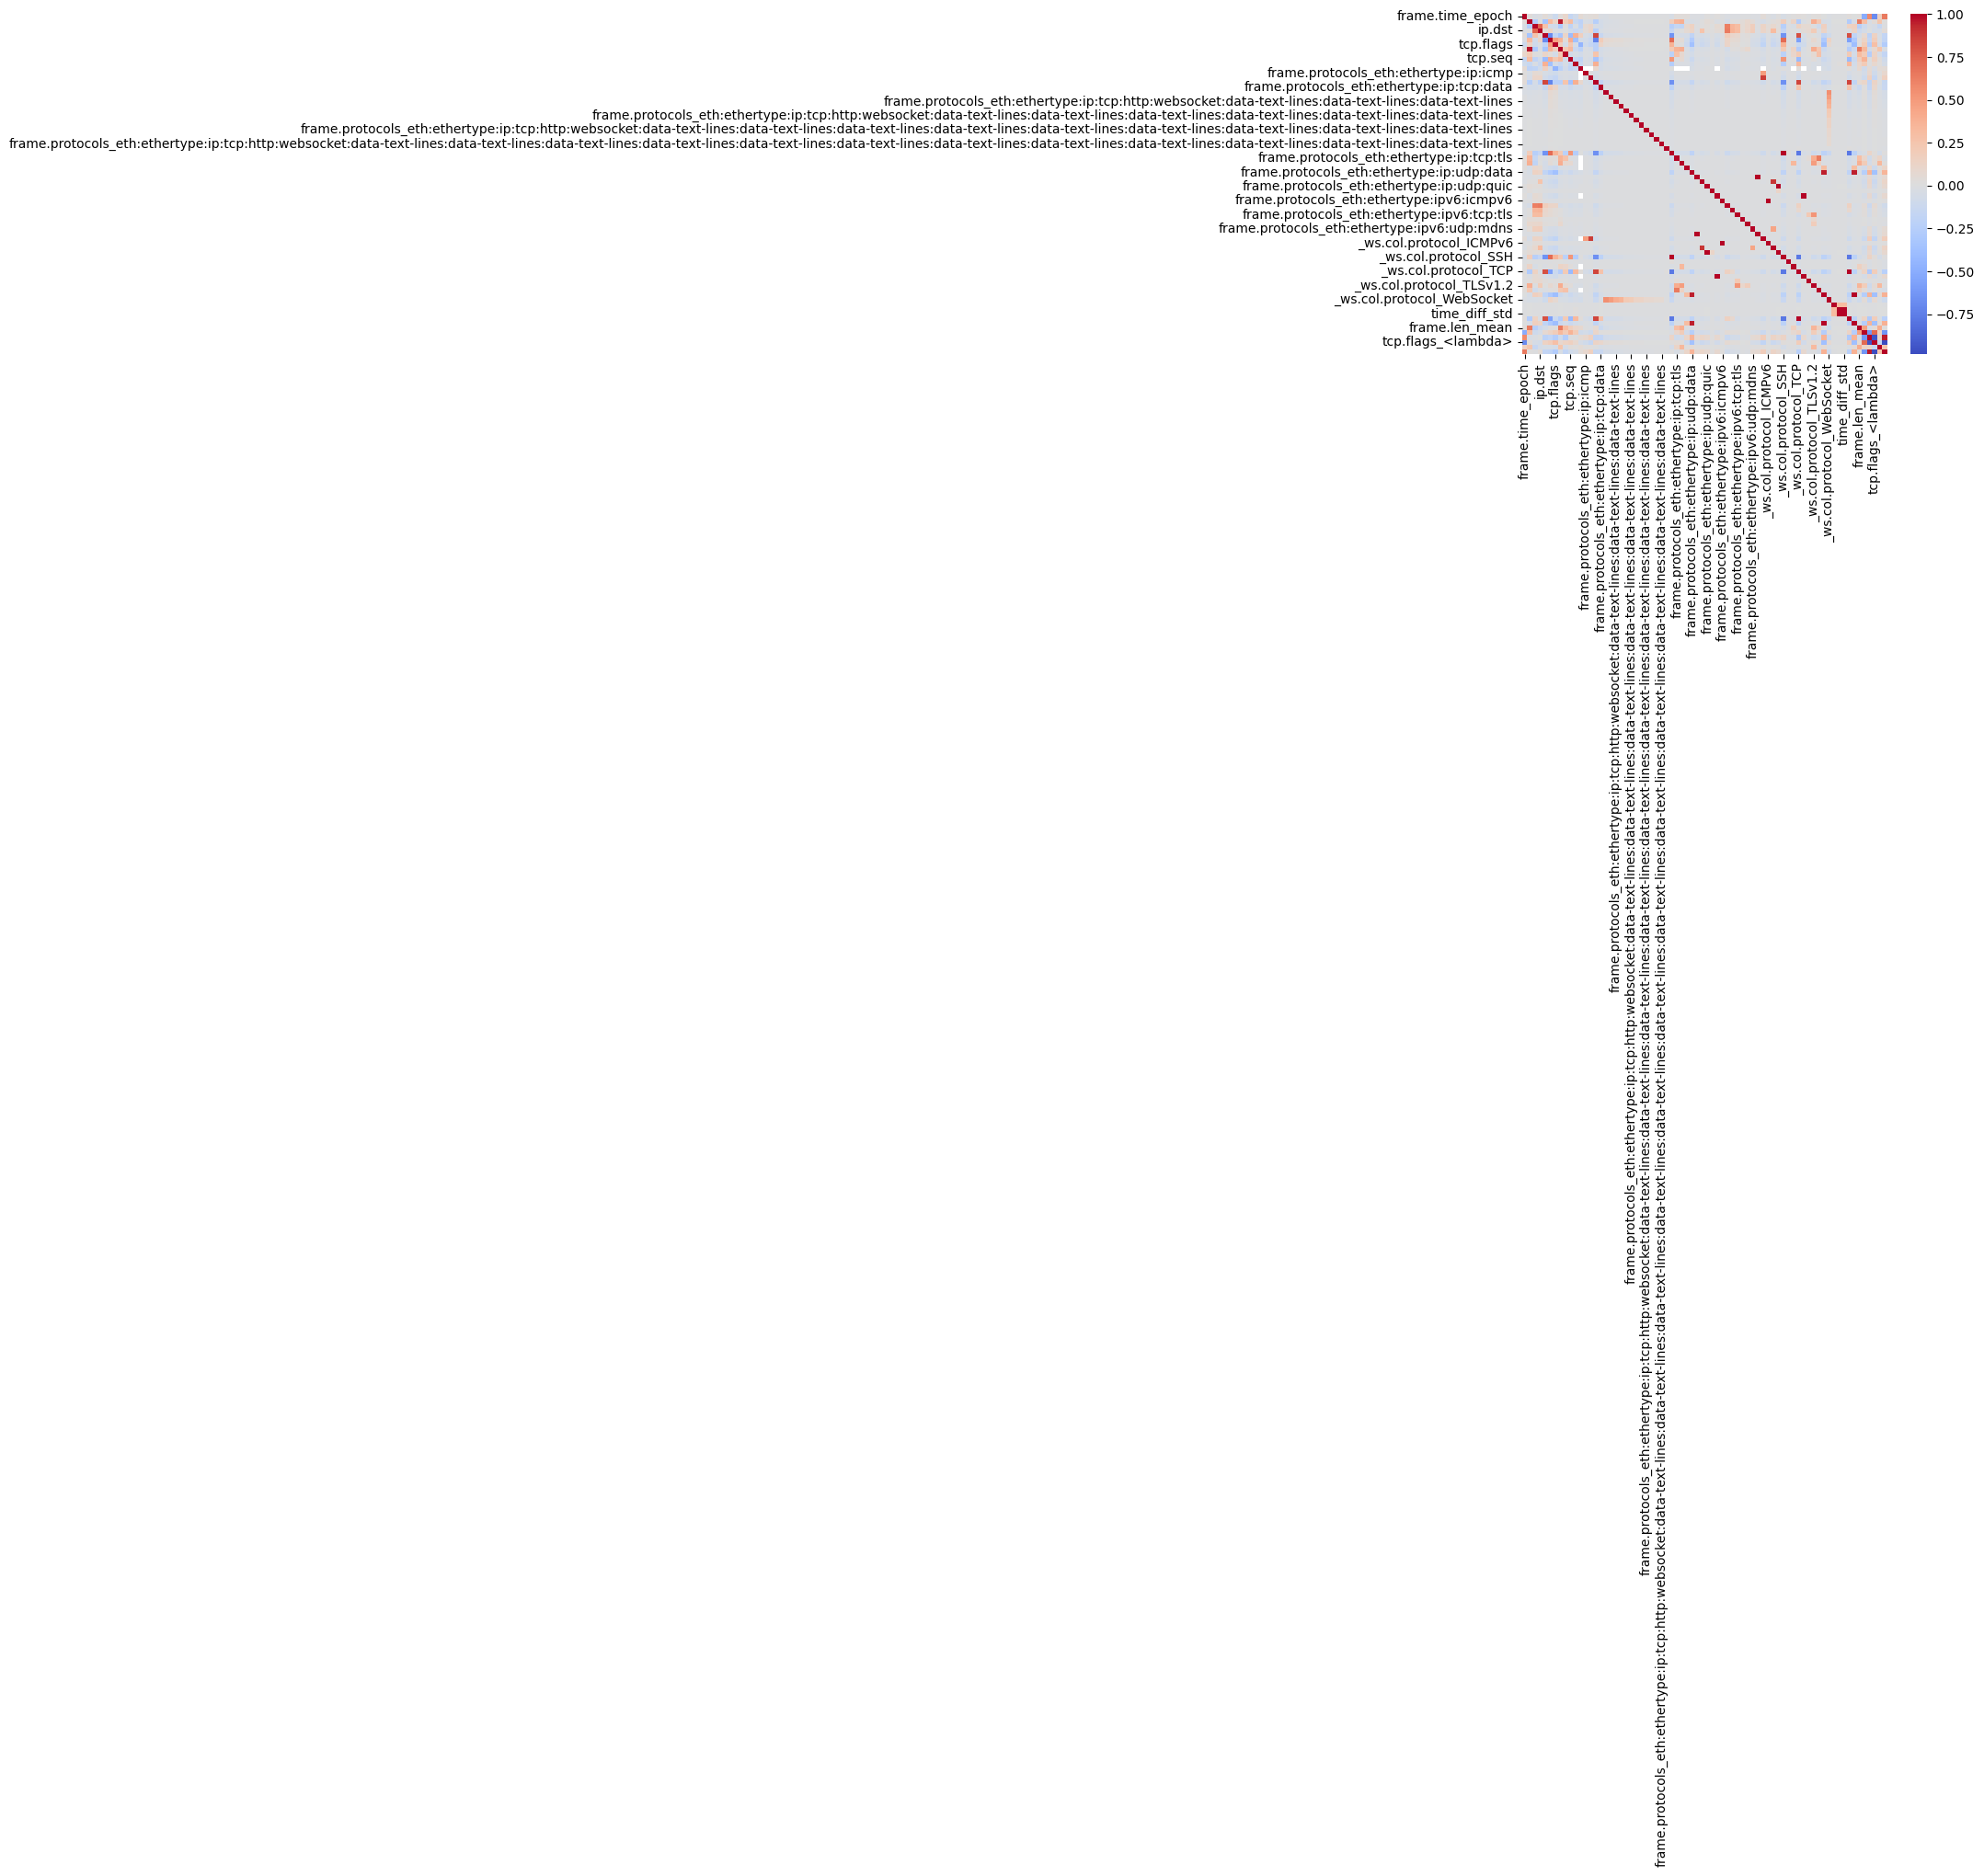

In [29]:
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

In [31]:
# Drop label for unsupervised learning
X_all = df.drop(columns=['label'])

## Exploratory Data Analysis (EDA)

## Model Training

### 1. Isolation Forest

In [32]:
from sklearn.ensemble import IsolationForest

# Initialize the model
iso_forest = IsolationForest(
    n_estimators=100,
    contamination='auto',  # or set based on known anomaly rate
    random_state=42
)

# Fit the model
iso_forest.fit(X_all)

# Predict anomalies
df['iso_forest_score'] = iso_forest.decision_function(X_all)
df['iso_forest_pred'] = iso_forest.predict(X_all)
# Convert predictions: -1 for anomalies, 1 for normal
df['iso_forest_pred'] = df['iso_forest_pred'].map({1: 0, -1: 1})  # 1 for anomaly

### 2. Local Outlier Factor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize the model
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination='auto',
    novelty=False  # LOF in outlier detection mode
)

# Fit and predict
lof_pred = lof.fit_predict(X_all)
df['lof_pred'] = lof_pred
df['lof_pred'] = df['lof_pred'].map({1: 0, -1: 1})  # 1 for anomaly

### 3. Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define Autoencoder architecture
input_dim = X_all.shape[1]
encoding_dim = 32  # Adjust based on data complexity

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
encoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(
    X_all, X_all,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

# Compute reconstruction error
reconstructions = autoencoder.predict(X_all)
mse = np.mean(np.power(X_all - reconstructions, 2), axis=1)
df['autoencoder_mse'] = mse

# Define anomaly threshold (e.g., based on percentile)
threshold = np.percentile(mse, 95)
df['autoencoder_pred'] = (df['autoencoder_mse'] > threshold).astype(int)

## 6. Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Filter labeled data
eval_df = df.dropna(subset=['label'])

# Map 0:1 to -1:1 for comparison
eval_df['label'] = eval_df['label'].map({0: -1, 1: 1})

# For each model, compare predictions with true labels
models = ['iso_forest_pred', 'lof_pred', 'autoencoder_pred']
for model in models:
    print(f"--- {model} ---")
    print(confusion_matrix(eval_df['label'], eval_df[model]))
    print(classification_report(eval_df['label'], eval_df[model]))
    # If binary classification, ROC AUC can be computed
    print("ROC AUC:", roc_auc_score(eval_df['label'], eval_df[model]))

## 7. Noise and Drift Tests
